In [1]:
# Importing Libraries

In [2]:
import pandas as pd
import numpy as np


In [3]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [4]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [5]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [6]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [7]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [8]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [9]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

/Users/sapansoni/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [10]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [11]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [12]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

### Model using 16 hidden units and moderate dropout rate

In [13]:
# Initializing parameters
epochs = 20
batch_size = 64
n_hidden = 16

In [14]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [15]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

In [16]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


- Defining the Architecture of LSTM

In [17]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden,return_sequences=True, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 16)           1664      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 16)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 102       
Total params: 3,878
Trainable params: 3,878
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [19]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/20
7352/7352 [==============================] - 23s 3ms/step - loss: 1.5757 - acc: 0.3595 - val_loss: 1.3929 - val_acc: 0.4143
Epoch 2/20
7352/7352 [==============================] - 21s 3ms/step - loss: 1.2752 - acc: 0.5086 - val_loss: 1.1857 - val_acc: 0.5612
Epoch 3/20
7352/7352 [==============================] - 21s 3ms/step - loss: 1.0965 - acc: 0.5853 - val_loss: 1.0097 - val_acc: 0.6081
Epoch 4/20
7352/7352 [==============================] - 24s 3ms/step - loss: 0.9847 - acc: 0.6179 - val_loss: 0.9297 - val_acc: 0.6396
Epoch 5/20
7352/7352 [==============================] - 24s 3ms/step - loss: 0.9133 - acc: 0.6261 - val_loss: 0.8403 - val_acc: 0.6366
Epoch 6/20
7352/7352 [==============================] - 21s 3ms/step - loss: 0.8503 - acc: 0.6389 - val_loss: 0.7966 - val_acc: 0.6271
Epoch 7/20
7352/7352 [==============================] - 26s 4ms/step - loss: 0.8203 - acc: 0.6495 - val_loss: 0.7650 - val_acc: 0.6281
Epoch 8

In [20]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 510        0         0        0                   0   
SITTING                  1      361       101       18                   0   
STANDING                 0       57       467        6                   0   
WALKING                  0        0         5      414                   7   
WALKING_DOWNSTAIRS       0        0         0       23                  12   
WALKING_UPSTAIRS         0        0         0        4                   2   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                            27  
SITTING                           10  
STANDING                           2  
WALKING                           70  
WALKING_DOWNSTAIRS               385  
WALKING_UPSTAIRS                 465  


In [21]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 3s 852us/step


In [22]:
score

[0.6035107239994875, 0.7563624024431626]

### Model using 32 hidden units and high dropout rate

In [23]:
# Initializing parameters
epochs = 20
batch_size = 32
n_hidden = 64
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden,return_sequences=True, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.7))
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
model.add(Dropout(0.7))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128, 64)           18944     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128, 64)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
Total params: 52,358
Trainable params: 52,358
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Training the model
model_log = model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/20
7352/7352 [==============================] - 64s 9ms/step - loss: 1.3477 - acc: 0.4170 - val_loss: 1.3952 - val_acc: 0.4147
Epoch 2/20
7352/7352 [==============================] - 62s 8ms/step - loss: 0.9861 - acc: 0.5700 - val_loss: 0.9066 - val_acc: 0.5965
Epoch 3/20
7352/7352 [==============================] - 63s 9ms/step - loss: 0.8310 - acc: 0.6245 - val_loss: 0.8091 - val_acc: 0.6634
Epoch 4/20
7352/7352 [==============================] - 63s 9ms/step - loss: 0.7241 - acc: 0.6427 - val_loss: 0.8131 - val_acc: 0.6749
Epoch 5/20
7352/7352 [==============================] - 63s 9ms/step - loss: 0.7398 - acc: 0.6756 - val_loss: 0.7638 - val_acc: 0.6885
Epoch 6/20
7352/7352 [==============================] - 64s 9ms/step - loss: 0.6331 - acc: 0.7297 - val_loss: 0.6992 - val_acc: 0.7346
Epoch 7/20
7352/7352 [==============================] - 63s 9ms/step - loss: 0.5737 - acc: 0.7578 - val_loss: 0.5913 - val_acc: 0.7323
Epoch 8

In [25]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 520        0         0        0                   0   
SITTING                  6      403        75        1                   1   
STANDING                 0       92       440        0                   0   
WALKING                  0        0         0      454                  13   
WALKING_DOWNSTAIRS       0        0         0        0                 418   
WALKING_UPSTAIRS         0        1         1       19                   2   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                            17  
SITTING                            5  
STANDING                           0  
WALKING                           29  
WALKING_DOWNSTAIRS                 2  
WALKING_UPSTAIRS                 448  


In [35]:
mat = confusion_matrix(Y_test, model.predict(X_test))

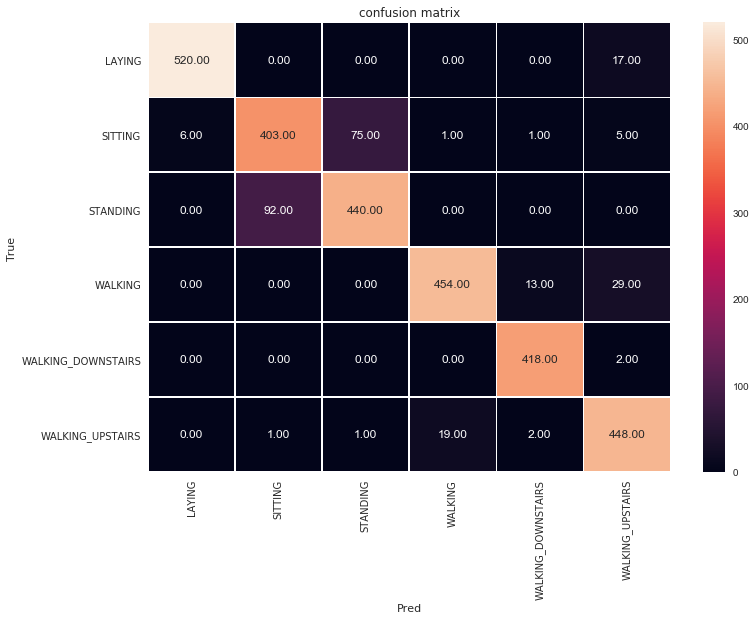

In [59]:
import seaborn as sns
plt.rcParams["font.family"] = 'DejaVu Sans'
plt.title("confusion matrix")
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.ylabel("True Value")
plt.xlabel("Predicted Value")
sns.heatmap(mat,annot=True,linewidths=.5,fmt = '.2f')



In [26]:
score = model.evaluate(X_test, Y_test)
score


2947/2947 [==============================] - 5s 2ms/step


[0.353041044472225, 0.9104173736002714]

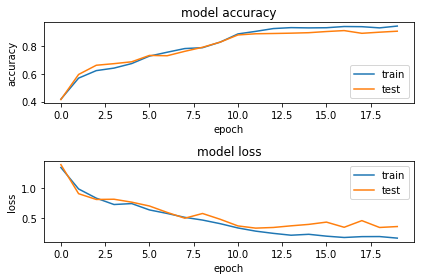

In [27]:
import os
# plotting the metrics
import matplotlib.pyplot as plt
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(model_log.history['acc'])
plt.plot(model_log.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(model_log.history['loss'])
plt.plot(model_log.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

fig

## CONCLUSIONS

- By using two LSTM with 16 hidden units , we got the accuracy of 75 %
- When we changed model to 32 hidden units , accuracy increased significantly to 91 % 
- From confusion matrix we can conclude that "Model is making error while classifying sitting and standing classes"